In [1]:
from src import *
from src.EAFSC import *
import matplotlib.pyplot as plt 
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score, fowlkes_mallows_score,silhouette_score,davies_bouldin_score
import pickle
import cv2
from torchvision import transforms
from transformers import AutoImageProcessor, AutoModel
import json
from torch_geometric.explain import Explainer, GNNExplainer
import networkx as nx

/d/hanr/anaconda3/envs/EMSC/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
parser = argparse.ArgumentParser()
parser.add_argument("--dataset", default='HERF1_phk2', help="The name of dataset.")
parser.add_argument("--checkpoint", default=1, help="1 represents using the trained model.")
parser.add_argument("--k", default=5, help="The number of neighbors. Default is 50")
parser.add_argument("--pca_dim", default=100, help="The dim of pca. Default is 1000")
parser.add_argument("--clus_num", default=4, help="The number of clusters.")

parser.add_argument("--threshold", default=650, help="The threshold of neighbors. Default is 500")
parser.add_argument("--topk", type=int, default=4, help="The number of neighbors to search")
parser.add_argument("--num_centroids", type=int, default=5, help="The number of centroids for K-means Clustering")
parser.add_argument("--num_kmeans", type=int, default=5, help="The number of K-means Clustering for being robust to randomness")
parser.add_argument("--device", type=int, default=2)

parser.add_argument("--layers", nargs='?', default='[128]', help="The number of units of each layer of the GNN. Default is [256]")
parser.add_argument("--pred_hid", type=int, default=256, help="The number of hidden units of layer of the predictor. Default is 512")
parser.add_argument("--clus_num_iters", type=int, default=20)
parser.add_argument("--eval_freq", type=float, default=5, help="The frequency of model evaluation")
parser.add_argument("--mad", type=float, default=0.999, help="Moving Average Decay for Teacher Network")
parser.add_argument("--lr", type=float, default=0.001, help="learning rate")    
parser.add_argument("--es", type=int, default=3000, help="Early Stopping Criterion")
parser.add_argument("--epochs", type=int, default=300)
parser.add_argument("--batch_size", type=int, default=100)
parser.add_argument("--n_heads", type=int, default=4)
parser.add_argument("--dropout", type=float, default=0.0)
args, _=parser.parse_known_args()

In [3]:
def save(args, save_dir):
    """将参数保存为JSON文件"""
    
    # 将Namespace对象转换为字典
    args_dict = vars(args)
    
    with open(save_dir, 'w') as f:
        json.dump(args_dict, f, indent=4)
    
    print(f"参数已保存至: {save_dir}")
    return save_dir

In [4]:
# chage to your own path.
adata_path = '/d/hanr/dataset/her2st-master' # This is the path where the file is located.
adata_name = 'F1' # This is the name of the h5 file.
image_path = '/d/hanr/dataset/her2st-master/data/ST-imgs/C/C1/C5714_HE_BT_C1.jpg'
save_feat = './results/feat/'+args.dataset+'.npy'
# save_img = './results/img/'+args.dataset
save_label = './results/label/'+args.dataset+'.csv'
save_model = './results/model/'+args.dataset+'.pkl'
save_args = './results/args/'+args.dataset+'.json'

In [5]:
adata = build_her2st_data(adata_path,adata_name)

AnnData object with n_obs × n_vars = 691 × 14861
    obsm: 'spatial', 'label' [ 2  2  2  0  2  2  2  2  2  2  2  2  2  2  1  1  1  0  0  0  0  2  0 -1
  1  1  2  2  2  2  2  2  2 -1 -1  2  2  2  2  2  2  2  2  2 -1  0  0  0
  0  0  0  2  1 -1  1  2  2  2  2  2  2  2  2  0  2  2  2  2  2  2  2  2
  2  2  2  2  0  0  0  0  0  2  2  1  1  2  2  2  2  2  2  2  2  0  2  2
  2  2  2  2  2  2  2  2  2  2  2  2 -1  0  0  0  1 -1  2  2  2  2  2  2
  2 -1  0  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  0 -1  2
  2  2  2  2  2  2  2 -1  2  2  2  2  2  2  2  2  2  2  2  2 -1  1  2  2
  2  2  2 -1  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2 -1 -1  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2 -1  2  2  2  0  0  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2 -1  0  2  2  0  0  2  2  2  2  2
  0  2  2  2  2  2  2  2  2  2  2  2  2  2  2 

/d/hanr/anaconda3/envs/EMSC/lib/python3.9/site-packages/anndata/_core/anndata.py:402: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


In [6]:
adata.obsm['X_pca'] = adata_preprocess_pca(adata, pca_n_comps=args.pca_dim).astype(np.float32)

In [7]:
label = adata.obsm['label']
adata = adata[label != -1]
print(adata)

View of AnnData object with n_obs × n_vars = 659 × 12967
    var: 'n_cells'
    obsm: 'spatial', 'label', 'X_pca'


In [8]:
args.clus_num=len(np.unique(adata.obsm['label']))
print(args.clus_num)

3


In [9]:
# img_size=112
# full_img = cv2.imread(image_path)
# # 步骤2: BGR转RGB (可选但推荐)
# full_img = cv2.cvtColor(full_img, cv2.COLOR_BGR2RGB)
# print(full_img.shape)
# patches = []
# # 步骤3: 使用PyTorch转换管道
# transform = transforms.Compose([
#     transforms.ToTensor(),  # 自动: 1. 转Tensor 2. HWC->CHW 3. 归一化到[0,1]
#     # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 如需标准化
# ])


# for x, y in adata.obsm['spatial']:
#     patch=full_img[y-img_size:y+img_size, x-img_size:x+img_size]
#     # 执行转换
#     tensor_patch = transform(patch)  # 得到 [3, 244, 244] 的FloatTensor
#     # print(full_image,full_image.shape)
#     print(patch.shape,tensor_patch.shape)
#     patches.append(tensor_patch.numpy())
# patches = np.array(patches)
# print(patches.shape)

In [10]:
# processor = AutoImageProcessor.from_pretrained("/d/hanr/phikon-v2")
# model = AutoModel.from_pretrained("/d/hanr/phikon-v2")
# model.eval()
# inputs = {"pixel_values":torch.from_numpy(patches).squeeze(dim=0)}
# with torch.inference_mode():
#     outputs = model(**inputs)
#     print(outputs.last_hidden_state,outputs.last_hidden_state.shape)
#     features = outputs.last_hidden_state[:, 0, :]  # (1, 1024) shape
#     print(features,features.shape)
#     np.save(f"/d/hanr/EMSC/results/img_feat_phi/"+args.dataset+".npy", features.numpy())

In [11]:
image_data = np.load("/d/hanr/EMSC/results/img_feat_phi/HERF1_phk.npy")
image_data = np.array(image_data)
image_data= torch.Tensor(image_data).cuda(args.device)
print(image_data,image_data.shape,image_data.device)


tensor([[-0.6787, -0.1708, -0.2817,  ..., -0.0898, -0.0952,  0.3725],
        [-0.6479,  0.1053, -0.2570,  ...,  0.0155, -0.1304,  0.2214],
        [-0.6318,  0.5521, -0.2725,  ...,  0.0400, -0.1070,  0.3646],
        ...,
        [-0.2158,  0.2102, -0.2374,  ..., -0.1116, -0.0378,  0.3186],
        [-0.4559,  0.2178, -0.4075,  ..., -0.3226, -0.0025,  0.2471],
        [-0.5285, -0.0096, -0.3329,  ..., -0.1303, -0.1772,  0.5548]],
       device='cuda:2') torch.Size([659, 1024]) cuda:2


In [12]:
position = np.ascontiguousarray(adata.obsm["spatial"]) 
#计算节点距离
DIS = squareform(pdist(position))
adata.obsm["distance"] = DIS
#k个邻居
n_spot = position.shape[0]
nbrs = NearestNeighbors(n_neighbors=args.k+1).fit(position)  
_ , indices = nbrs.kneighbors(position)
x = indices[:, 0].repeat(args.k)
y = indices[:, 1:].flatten()
interaction = np.zeros([n_spot, n_spot])
interaction[x, y] = 1
#transform adj to symmetrical adj
adj_k = interaction
adj_k = adj_k + adj_k.T
adj_k = np.where(adj_k>1, 1, adj_k)
# print(adj,adj.shape,np.count_nonzero(adj))
adata.obsm['adj_k'] = adj_k
#计算knn节点距离
DIS_K=np.multiply(DIS,adj_k)
adata.obsm['distance_k'] = DIS_K
print(adata)

AnnData object with n_obs × n_vars = 659 × 12967
    var: 'n_cells'
    obsm: 'spatial', 'label', 'X_pca', 'distance', 'adj_k', 'distance_k'


/tmp/ipykernel_1932118/1778445592.py:4: ImplicitModificationWarning: Setting element `.obsm['distance']` of view, initializing view as actual.
  adata.obsm["distance"] = DIS


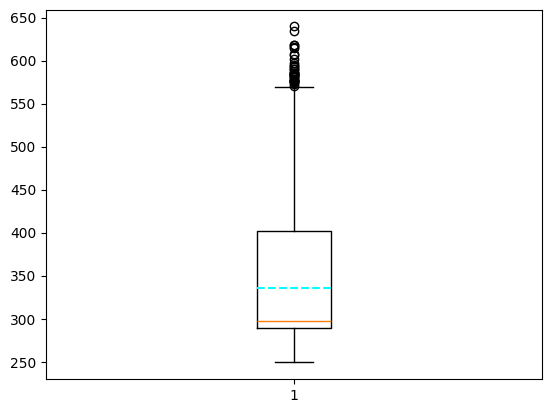

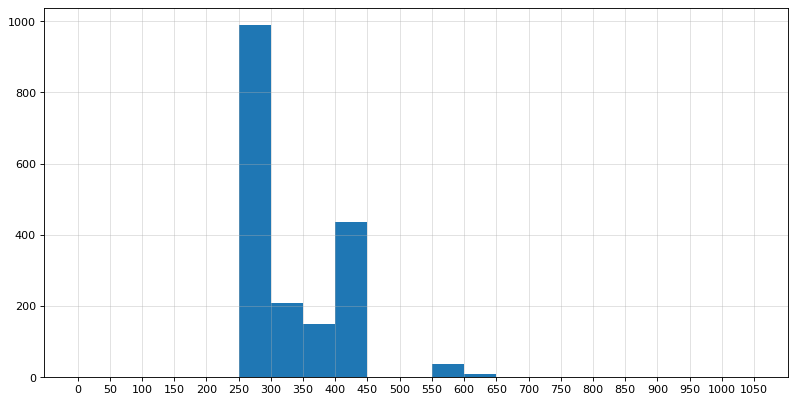

In [13]:
DIS_K=adata.obsm['distance_k']
DIS_K_plot=DIS_K[np.triu_indices(DIS_K.shape[0],k=1)]
DIS_K_plot=DIS_K_plot[DIS_K_plot>0] 
#箱线图
plt.boxplot(DIS_K_plot, showmeans=True, meanline=True,meanprops={'color': 'cyan', 'linewidth': 1.5})
plt.show()
num_bin=[0]
#直方图
i=0
while i<=1000:
    i+=50
    num_bin.append(i)
plt.figure(dpi=80,figsize=(12,6))
plt.hist(DIS_K_plot, num_bin)
plt.xticks(num_bin)
plt.grid(alpha=0.4)
plt.show()

In [25]:
def plot(adata):
    a = np.array(adata.obs["pred"]).astype(int)
    a = np.squeeze(a)
    position = np.ascontiguousarray(adata.obsm["spatial"]) 
    x = np.ascontiguousarray(position[:,0])
    y = np.ascontiguousarray(position[:,1])
    n = len(np.unique(adata.obs["pred"]))
    print(n)
    plt.rcParams['axes.unicode_minus']=False
    ax=plt.scatter(x,y, c=a,cmap='Spectral', s=n) 
    ax.axes.invert_yaxis()
    plt.gca().set_aspect('equal', 'datalim') 
    # plt.colorbar(boundaries=np.arange(n+1)-0.5).set_ticks(np.arange(n))
    
    plt.legend(handles=ax.legend_elements(num=range(n))[0],labels=range(n),loc=2, bbox_to_anchor=(1.01,1.0))
    plt.show()

In [26]:
torch.cuda.empty_cache()

In [27]:
def train(adata,threshold):
        data = prepare_data(adata,threshold)
        model_AFSL =EAFSCcluster()
        #Run
        model_AFSL.train(data,image_data,args,n_clusters=args.clus_num,init_spa=True,res=0.7, tol=5e-3, lr=0.05, max_epochs=args.epochs,nhid=128)
        x,y_pred=model_AFSL.predict()
        refined_pred=refine(adata,sample_id=adata.obs.index.tolist(), pred=y_pred.tolist())
        adata.obs["pred"]=refined_pred
        NMI = normalized_mutual_info_score(adata.obsm["label"], adata.obs["pred"], average_method='arithmetic')
        ARI = adjusted_rand_score(adata.obsm["label"], adata.obs["pred"])
        FMI = fowlkes_mallows_score(adata.obsm["label"], adata.obs["pred"]) 
        SC = silhouette_score(x.cpu().detach().numpy(), adata.obs["pred"])
        DBI = davies_bouldin_score(x.cpu().detach().numpy(), adata.obs["pred"])
        print('===== ARI:{:.3f},NMI:{:.3f},FMI:{:.3f},SC:{:.3f},DBI:{:.3f} ===='.format(ARI,NMI,FMI,SC,DBI))
        plot(adata)
        torch.cuda.empty_cache()

In [28]:
def test(adata,checkpoint_path):
    save_pred= pd.read_csv(save_label,sep='\t')
    save_x=np.load(save_feat)
    NMI_ = normalized_mutual_info_score(adata.obsm["label"], save_pred.values.flatten(), average_method='arithmetic')
    ARI_ = adjusted_rand_score(adata.obsm["label"], save_pred.values.flatten())
    FMI_ = fowlkes_mallows_score(adata.obsm["label"], save_pred.values.flatten()) 
    SC_ = silhouette_score(save_x, save_pred.values.flatten())
    DBI_ = davies_bouldin_score(save_x, save_pred.values.flatten())
    print('===== ARI:{:.3f},NMI:{:.3f},FMI:{:.3f},SC:{:.3f},DBI:{:.3f} ===='.format(ARI_,NMI_,FMI_,SC_,DBI_))
    adata.obs["pred"]=save_pred.values.flatten()
    adata.obsm['EMSC']=save_x

In [ ]:
if args.checkpoint == 0:
    train(adata,args.threshold)
else:
    test(adata,save_model)

In [30]:
bdata = build_her2st_data(adata_path,adata_name)
def fill_true_positions_efficient(A, B, placeholder=args.clus_num):
    """
    更高效的填充实现
    
    参数:
    A (list[bool]): 布尔值列表
    B (list): 要填充的值列表
    placeholder: 用于False位置的占位符
    
    返回:
    list: 填充后的列表C
    """
    # 创建B的迭代器
    b_iter = iter(B)
    
    # 使用列表推导式构建结果
    return [next(b_iter) if is_true else placeholder for is_true in A]

# 使用相同的示例
bdata.obs['pred'] = fill_true_positions_efficient(bdata.obsm['label'], adata.obs['pred'])
print(bdata.obs['pred'])  # 输出: [-1, 0, -1, 2, 1]

AnnData object with n_obs × n_vars = 691 × 14861
    obsm: 'spatial', 'label' [ 2  2  2  0  2  2  2  2  2  2  2  2  2  2  1  1  1  0  0  0  0  2  0 -1
  1  1  2  2  2  2  2  2  2 -1 -1  2  2  2  2  2  2  2  2  2 -1  0  0  0
  0  0  0  2  1 -1  1  2  2  2  2  2  2  2  2  0  2  2  2  2  2  2  2  2
  2  2  2  2  0  0  0  0  0  2  2  1  1  2  2  2  2  2  2  2  2  0  2  2
  2  2  2  2  2  2  2  2  2  2  2  2 -1  0  0  0  1 -1  2  2  2  2  2  2
  2 -1  0  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  0 -1  2
  2  2  2  2  2  2  2 -1  2  2  2  2  2  2  2  2  2  2  2  2 -1  1  2  2
  2  2  2 -1  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2 -1 -1  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2 -1  2  2  2  0  0  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2 -1  0  2  2  0  0  2  2  2  2  2
  0  2  2  2  2  2  2  2  2  2  2  2  2  2  2 

/d/hanr/anaconda3/envs/EMSC/lib/python3.9/site-packages/anndata/_core/anndata.py:402: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


3


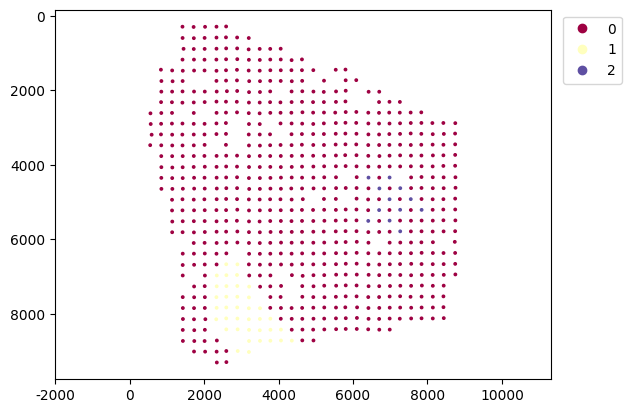

In [31]:
plot(adata)

In [32]:
bdata.obsm['label']=bdata.obsm['label']+1

4


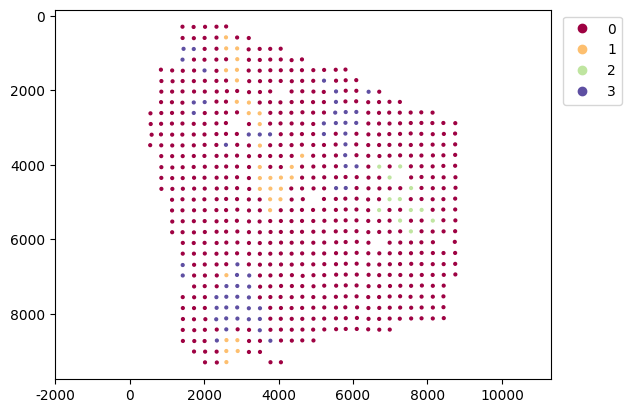

In [33]:
plot(bdata)

In [34]:
print(adata.obs['pred'])
adata.obs['pred'] = adata.obs['pred'].astype('category')
print(adata.obs['pred'])

10x10    0
10x11    0
10x12    0
10x13    0
10x14    0
        ..
9x5      0
9x6      0
9x7      0
9x8      0
9x9      0
Name: pred, Length: 659, dtype: int64
10x10    0
10x11    0
10x12    0
10x13    0
10x14    0
        ..
9x5      0
9x6      0
9x7      0
9x8      0
9x9      0
Name: pred, Length: 659, dtype: category
Categories (3, int64): [0, 1, 2]


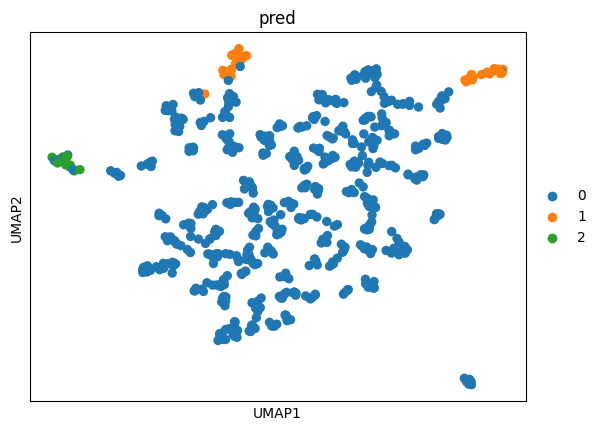

In [35]:
sc.pp.neighbors(adata, n_neighbors=10,use_rep='EMSC')
sc.tl.umap(adata)
sc.pl.umap(adata, color=["pred"])